In [3]:
import numpy as np
np.arange(320,1440,10)

array([ 320,  330,  340,  350,  360,  370,  380,  390,  400,  410,  420,
        430,  440,  450,  460,  470,  480,  490,  500,  510,  520,  530,
        540,  550,  560,  570,  580,  590,  600,  610,  620,  630,  640,
        650,  660,  670,  680,  690,  700,  710,  720,  730,  740,  750,
        760,  770,  780,  790,  800,  810,  820,  830,  840,  850,  860,
        870,  880,  890,  900,  910,  920,  930,  940,  950,  960,  970,
        980,  990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080,
       1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190,
       1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300,
       1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410,
       1420, 1430])

In [ ]:
import subprocess
import pandas as pd
import numpy as np

# parameters (change as needed)
mjd_start_values = [57001.416667]
mjd_end_values = [57002]
nspan_values = [300]
ncoeffs_values = [3]
maxha_values = [8.0]
telescope_code_values = ['GMRT']
frequencies = np.arange(320,1440,10)

# generate input files for different parameter combinations
with open("output_file.txt", 'w') as file:
    for frequency in frequencies:
        for mjd_start in mjd_start_values:
            for mjd_end in mjd_end_values:
                for nspan in nspan_values:
                    for ncoeffs in ncoeffs_values:
                        for maxha in maxha_values:
                            for telescope_code in telescope_code_values: 
                                    output_file = f"tempo2_input_{mjd_start}_{mjd_end}_{nspan}_{ncoeffs}_{maxha}_{telescope_code}_{frequency}.txt"
                                    parameter_values = [mjd_start, mjd_end, nspan, ncoeffs, maxha, telescope_code, frequency]
                                    line = " ".join(map(str, parameter_values)) + "\n"
                                    file.write(line)

#AWK commands

#To capture the paramaters from the parameter sweep file and run tempo2 polyco on it 
with open("tempo_param_capture.awk", 'r') as awk_file:
    awk_command = awk_file.read()
subprocess.run(f'awk \'{awk_command}\' output_file.txt | sh', shell=True)

#To extract the coefficients and required constants from output of tempo2 to calculate phase and frequency 
#with open("fsweep_extract_coeff.awk", 'r') as awk_file:
    #awk_command = awk_file.read()
#subprocess.run(f'awk \'{awk_command}\' *polyco_new.dat | sh', shell=True)

#Calculate phae and frequency 

def calculate_phase_and_frequency(mjd, tmid, rphase, coeff1, coeff2, coeff3,f0):
    # Calculate the time difference in minutes
    dt = (mjd - tmid) * 1440

    # Calculate phase
    phase = rphase + dt * 60 * f0 + coeff1 + dt * coeff2 + dt**2 * coeff3
    
    norm_phase  = phase% 1
    # Calculate frequency in Hz
    freq = f0+ (1 / 60) * (coeff2 + 2 * dt * coeff3)

    return phase, freq,norm_phase

df=[]
#freq_sweep = [320,322,324,326,330,332,340,380,400]
mjd_input = 57001.43000  # Replace with the desired MJD value
#f0 = 11.188233045354
output_pred = []


for frequ in range(len(frequencies)):
    
    #To extract the coefficients and required constants from output of tempo2 to calculate phase and frequency 
    with open("fsweep_extract_coeff.awk", 'r') as awk_file:
        awk_command = awk_file.read()
        command = f'awk \'{awk_command}\' {frequencies[frequ]}polyco_new.dat'
        subprocess.run(command, shell=True, check=True)
    
    file_path = f'coeff_data_{frequencies[frequ]}.dat'
    df = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=['Pulsar', 'TMID', 'F0','RPHASE', 'COEFF1', 'COEFF2', 'COEFF3'],skiprows=1)
    
    for index, row in df.iterrows():
        psrname, tmid, f0,rphase, coeff1, coeff2, coeff3 = row
        phase,freq,norm_phase = calculate_phase_and_frequency(mjd_input, tmid, rphase, coeff1, coeff2, coeff3,f0)
        output = [psrname,frequencies[frequ],tmid,mjd_input,phase,norm_phase,freq]
        output_pred.append(output)
        print(f"Pulsar: {psrname}, Freq = {frequencies[frequ]}, MJD: {mjd_input}, Phase: {phase}, Frequency: {freq} Hz")



In [5]:
#This was done to avoid the running polyco again 
import pandas as pd
import numpy as np
frequencies = np.arange(320,1440,10)


In [6]:
#Calculate phae and frequency 

def calculate_phase_and_frequency(mjd, tmid, rphase, coeff1, coeff2, coeff3,f0):
    # Calculate the time difference in minutes
    dt = (mjd - tmid) * 1440

    # Calculate phase
    phase = rphase + dt * 60 * f0 + coeff1 + dt * coeff2 + dt**2 * coeff3
    
    norm_phase  = phase% 1
    # Calculate frequency in Hz
    freq = f0+ (1 / 60) * (coeff2 + 2 * dt * coeff3)

    return phase, freq,norm_phase

df=[]
#freq_sweep = [320,322,324,326,330,332,340,380,400]
mjd_input = 57001.43000  # Replace with the desired MJD value
#f0 = 11.188233045354
output_pred = []


for frequ in range(len(frequencies)):
    
    #To extract the coefficients and required constants from output of tempo2 to calculate phase and frequency 
    with open("fsweep_extract_coeff.awk", 'r') as awk_file:
        awk_command = awk_file.read()
        command = f'awk \'{awk_command}\' {frequencies[frequ]}polyco_new.dat'
        subprocess.run(command, shell=True, check=True)
    
    file_path = f'coeff_data_{frequencies[frequ]}.dat'
    df = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=['Pulsar', 'TMID', 'F0','RPHASE', 'COEFF1', 'COEFF2', 'COEFF3'],skiprows=1)
    
    for index, row in df.iterrows():
        psrname, tmid, f0,rphase, coeff1, coeff2, coeff3 = row
        phase,freq,norm_phase = calculate_phase_and_frequency(mjd_input, tmid, rphase, coeff1, coeff2, coeff3,f0)
        output = [psrname,frequencies[frequ],tmid,mjd_input,phase,norm_phase,freq]
        output_pred.append(output)
        print(f"Pulsar: {psrname}, Freq = {frequencies[frequ]}, MJD: {mjd_input}, Phase: {phase}, Frequency: {freq} Hz")

Pulsar: 0835-4510, Freq = 320, MJD: 57001.43, Phase: 616158186.1897135, Frequency: 11.18793539999906 Hz
Pulsar: 0835-4510, Freq = 320, MJD: 57001.43, Phase: 616158185.8615333, Frequency: 11.187956437866424 Hz
Pulsar: 0835-4510, Freq = 320, MJD: 57001.43, Phase: 616158186.6250032, Frequency: 11.18792805163612 Hz
Pulsar: 0835-4510, Freq = 320, MJD: 57001.43, Phase: 616158188.8411384, Frequency: 11.187863404402478 Hz
Pulsar: 0835-4510, Freq = 330, MJD: 57001.43, Phase: 616158188.0256352, Frequency: 11.187935400405532 Hz
Pulsar: 0835-4510, Freq = 330, MJD: 57001.43, Phase: 616158187.6974651, Frequency: 11.187956437672737 Hz
Pulsar: 0835-4510, Freq = 330, MJD: 57001.43, Phase: 616158188.4609601, Frequency: 11.187928050439249 Hz
Pulsar: 0835-4510, Freq = 330, MJD: 57001.43, Phase: 616158190.6770755, Frequency: 11.187863403732917 Hz
Pulsar: 0835-4510, Freq = 340, MJD: 57001.43, Phase: 616158189.7019573, Frequency: 11.187935400776322 Hz
Pulsar: 0835-4510, Freq = 340, MJD: 57001.43, Phase: 6161

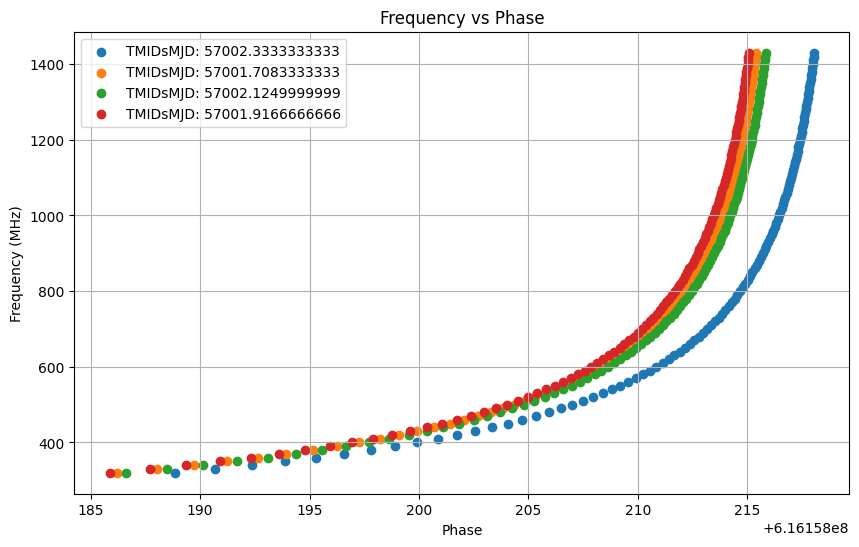

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize empty lists to store values
freq_values = []
phase_values = []
norm_phase_values = []
tmids = []

# Your existing loop
for i in range(len(frequencies)):
    freq_values_tmidmjd = output_pred[i][1]
    phase_values_tmidmjd = output_pred[i][4]
    norm_phase_values_tmidmjd = output_pred[i][5]
    tmidmjd = output_pred[i][2]
    
    # Append values to the lists
    freq_values.append(freq_values_tmidmjd)
    phase_values.append(phase_values_tmidmjd)
    norm_phase_values.append(norm_phase_values_tmidmjd)
    tmids.append(tmidmjd)

# Create a DataFrame
df_result = pd.DataFrame({
    'Frequency': freq_values,
    'Phase': phase_values,
    'Norm_Phase': norm_phase_values
})

# Get unique MJD values
unique_mjd_values = list(set(tmids))

# Plotting for each MJD
plt.figure(figsize=(10, 6))
for mjd_value in unique_mjd_values:
    indices = [i for i, value in enumerate(tmids) if value == mjd_value]
    plt.scatter([phase_values[i] for i in indices], [freq_values[i] for i in indices], marker='o', label=f'TMIDsMJD: {mjd_value}')

plt.title('Frequency vs Phase')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Phase')
plt.legend()
plt.grid(True)
plt.show()



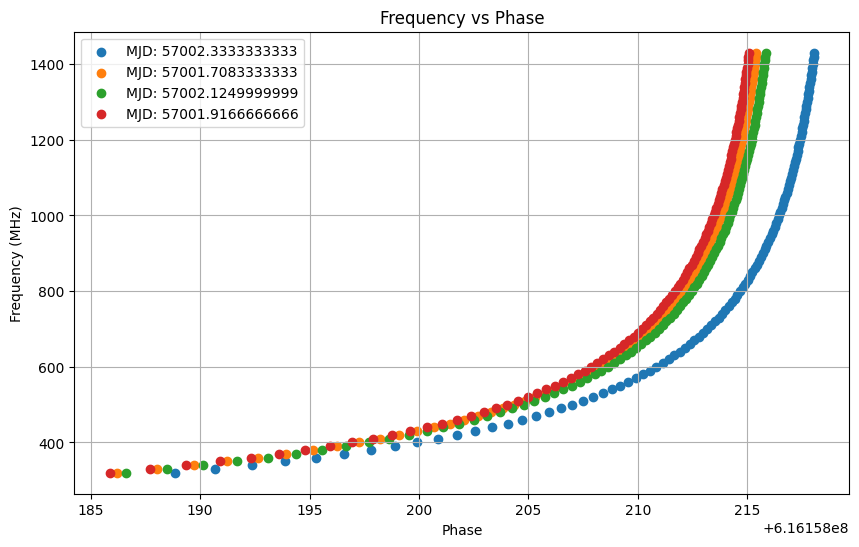

In [17]:
# Initialize empty lists to store values
freq_values = []
phase_values = []
norm_phase_values = []
tmids = []

# Your existing loop
for i in range(len(frequencies)):
    freq_values_tmidmjd = output_pred[i][1]
    phase_values_tmidmjd = output_pred[i][4]
    norm_phase_values_tmidmjd = output_pred[i][5]
    tmidmjd = output_pred[i][2]
    
    # Append values to the lists
    freq_values.append(freq_values_tmidmjd)
    phase_values.append(phase_values_tmidmjd)
    norm_phase_values.append(norm_phase_values_tmidmjd)
    tmids.append(tmidmjd)

# Create a DataFrame
df_result = pd.DataFrame({
    'Frequency': freq_values,
    'Phase': phase_values,
    'Norm_Phase': norm_phase_values
})

# Get unique MJD values
unique_mjd_values = list(set(tmids))

# Plotting for each MJD
plt.figure(figsize=(10, 6))
for mjd_value in unique_mjd_values:
    indices = [i for i, value in enumerate(tmids) if value == mjd_value]
    plt.scatter([phase_values[i] for i in indices], [freq_values[i] for i in indices], marker='o', label=f'MJD: {mjd_value}')

plt.title('Frequency vs Phase')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Phase')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
#plt.subplot(2, 1, 1)  # Frequency vs Phase
plt.plot((df_result['Phase']),(df_result['Frequency']), marker='o', linestyle='-')
plt.title('Frequency vs Phase')
plt.xlabel('Phase')
plt.ylabel('Frequency[MHz]')

#plt.subplot(2, 1, 2)  # Frequency vs Normalized Phase
#plt.plot(df_result['Norm_Phase'], df_result['Frequency'], marker='o', linestyle='-')
#plt.title('Frequency vs Normalized Phase')
#plt.xlabel('Normalized Phase')
#plt.ylabel('Frequency[MHz]')

plt.tight_layout()
plt.grid()
plt.show()

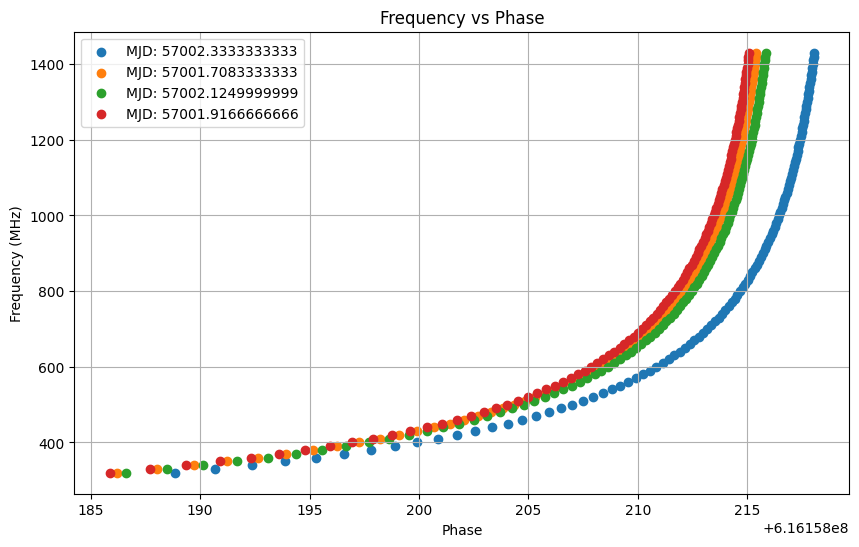

In [12]:
import matplotlib.pyplot as plt

# Extract data for plotting
pulsar_names = [output[0] for output in output_pred]
freq_pulsar = [output[6] for output in output_pred]
frequencies = [output[1] for output in output_pred]
t_mid = [output[2] for output in output_pred]
norm_phases = [output[4] for output in output_pred]

# Get unique MJD values
unique_mjd_values = list(set(t_mid))

# Plotting for each MJD
plt.figure(figsize=(10, 6))
for mjd_value in unique_mjd_values:
    indices = [i for i, value in enumerate(t_mid) if value == mjd_value]
    plt.scatter([norm_phases[i] for i in indices], [frequencies[i] for i in indices], marker='o', label=f'MJD: {mjd_value}')

plt.title('Frequency vs Phase')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Phase')
plt.legend()
plt.grid(True)
plt.show()
